In [163]:
import numpy as np
import pandas as pd
import joblib
from matplotlib.pyplot import subplots
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          plot_tree)

from sklearn.ensemble import (RandomForestClassifier as RFC,
                              GradientBoostingClassifier as GBC,
                              HistGradientBoostingClassifier as HGBC)
from sklearn.metrics import (RocCurveDisplay,
                             roc_auc_score,
                             roc_curve)

import sklearn.model_selection as skm
from ISLP import confusion_table
from ISLP.models import ModelSpec as MS
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from collections import Counter

We will start with loading our datasets: the full dataset ('full_cleaned_dataset') and the dataset with the outliers removed ('3std_dataset'), which also has a different target variable in 'unhealthy', that we've determined using the Altman Z-score during the Logistic Regression analysis.

In [164]:
df = pd.read_csv('./datasets/full_cleaned_dataset.csv')
df3 = pd.read_csv('./datasets/3std_dataset.csv')

df.info()
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Columns: 110 entries, date to marketcap
dtypes: float64(91), int64(14), object(5)
memory usage: 791.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Columns: 112 entries, date to unhealthy
dtypes: float64(107), object(5)
memory usage: 623.1+ KB


Let's start off by creating a basic tree model using the full dataset, just to see how such a decision tree looks like. Later we will create more complex models which will use a many trees (incidentally called a forest). Since a forest is made out of a large number of trees, which all are supposed to have a different strucuture, it will not make sense to look at an individual tree at that point.

In [165]:
# removing non-numeric columns
df = df.select_dtypes(include=[np.number])


# splitting the data into training and test sets
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(df.drop(columns=['distressed']),
                                df['distressed'],
                                test_size=0.3,
                                random_state=0)
 
feature_names_01 = df.drop(columns=['distressed']).columns.tolist()

In [166]:
# creating a model using the DecisionTreeClassifier
clf = DTC(criterion='gini',
          random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

Now that we have create basic decision tree using the training set, we can evaluate the model with the test set. Using a confusion matrix is a goodway to gauge the performance of the model, in a easy to read format. The accuracy score, which can be derived from the confusion matrix, expresses the "goodness" of the model in a single number. 

In [167]:
print(confusion_table(clf.predict(X_test), y_test))
print(f"Accuracy score: {clf.score(X_test, y_test):.3f}")
print(f"ROC AUC score: {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]):.3f}")

Truth        0  1
Predicted        
0          262  4
1            5  6
Accuracy score: 0.968
ROC AUC score: 0.791


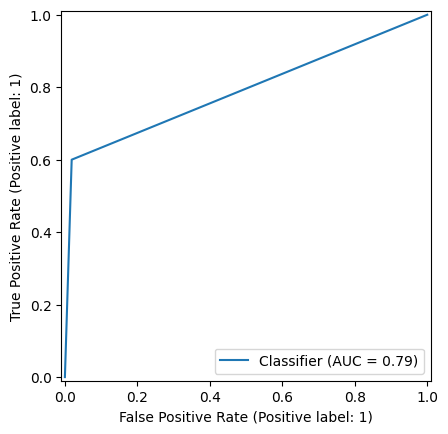

In [168]:
roc = RocCurveDisplay.from_predictions
y_score = clf.predict_proba(X_test)[:, 1]

roc(y_test, y_score)

We end up with a model that has an extremely high accuracy score. We could call it a day already, since we already seem to have a great model, that can predict the target variable with the given data. There is a good chance that the model is simply overfitting.
Let's look at the importance of the features in the model. And then let's visualize the tree, so we follow for ourselves, how the model is making its decisions to classify the data as "distressed".

In [169]:
feature_importances = pd.DataFrame({'importance':clf.feature_importances_}, index=feature_names_01)
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(10)

,importance
year,0.310689
totalDebt,0.116627
ebitda,0.112293
commonStockIssued,0.090066
totalEquity,0.088242
otherCurrentLiabilities,0.067232
revenue,0.056369
changeInWorkingCapital,0.045381
otherNonCurrentAssets,0.041799
interestExpense,0.037650


The most important feature seems to be 'year'. Which is a little awkward, this means that on of the best ways to determine whether a company is 'distressed' or not, is to check the calendar year in which the data is from. Interpolating this to a real world example, it might mean that a company won't be classified as distressed, because in my dataset there are no distressed companies in 2025. 
Now let's look at the full tree. 

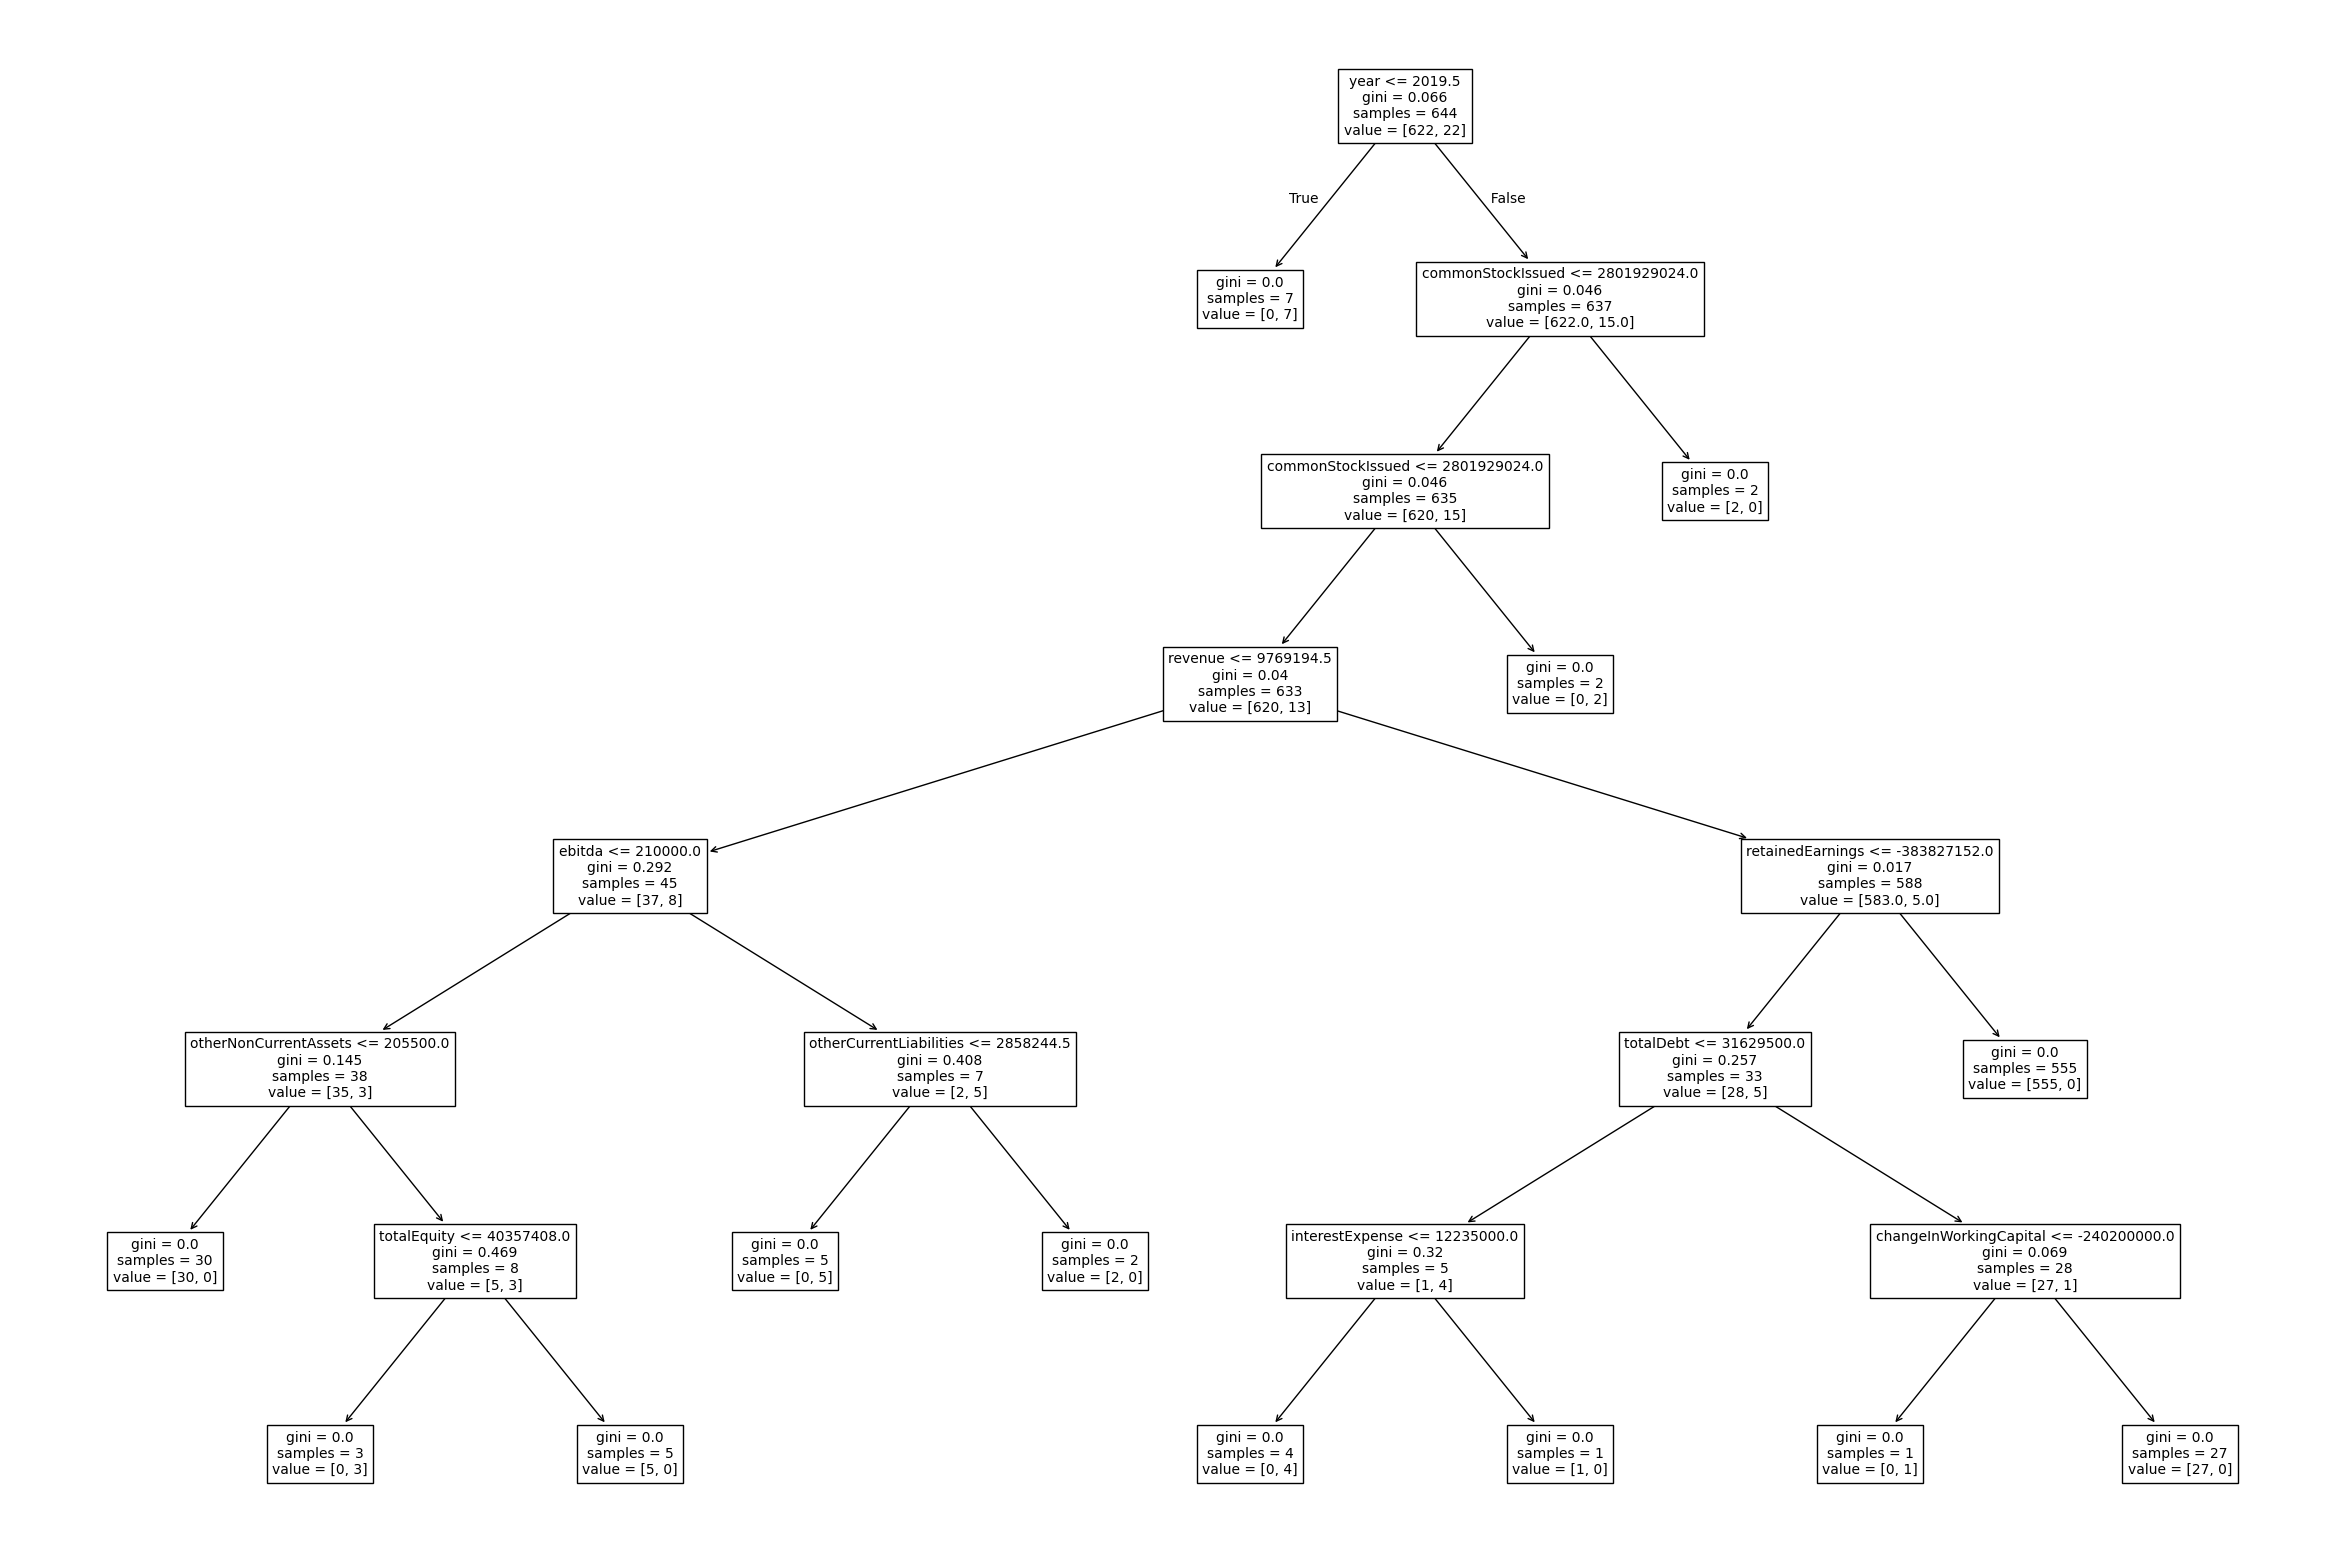

In [170]:
ax = subplots(figsize=(30,20))[1]
plot_tree(clf,
    feature_names=feature_names_01,
    ax=ax);

Let's also take a look at the years of the distressed companies in the dataset, to get a better understanding of why year is such an important feature.

In [171]:
# print year where distressed is 1
print(df[df['distressed'] == 1]['year'].value_counts())

year
2020    8
2021    6
2022    5
2019    5
2023    3
2018    3
2017    2
Name: count, dtype: int64


In [172]:
# save the model
joblib.dump(clf, './models/tree_01.pkl')

['./models/tree_01.pkl']

We could further work on this single tree by pruning it or experimenting with feature selection (so that year isn't taken into consideration, for example). But we can keep our finding in mind and instead move on to more complex models based on trees.

Let's use the 3std dataset to create a new tree model using a method called boosting. Boosting is a type of ensemble learning. In boosting we create a tree model and iteratively improve it by adding new treest to the model. Each new tree is trained to correct the errors of the previous tree. This way we should end up with a better model than we could create with a single tree.

In [173]:
# create training and test sets for the 3std dataset
# drop columns we don't want to use as features
# distressed, since it's a competing target, z_score since unhealthy is derived from it
df3.drop(columns=['distressed', 'z_score'], inplace=True)
df3 = df3.select_dtypes(include=[np.number])

(X3_train,
 X3_test,
 y3_train,
 y3_test) = skm.train_test_split(df3.drop(columns=['unhealthy']),
                                df3['unhealthy'],
                                test_size=0.3,
                                random_state=0)
 
feature_names_02 = df3.drop(columns=['unhealthy']).columns.tolist()

In [174]:
# train models using gradient boosting classifier (default parameters, verbose for logging)

boost_3std = GBC(verbose=1)
boost_3std.fit(X3_train, y3_train)

      Iter       Train Loss   Remaining Time 
         1           1.2740            1.13s
         2           1.1858            1.13s
         3           1.1100            1.14s
         4           1.0452            1.16s
         5           0.9849            1.16s
         6           0.9339            1.15s
         7           0.8726            1.12s
         8           0.8291            1.10s
         9           0.7801            1.09s
        10           0.7351            1.07s
        20           0.4504            0.96s
        30           0.3032            0.84s
        40           0.2113            0.72s
        50           0.1584            0.61s
        60           0.1204            0.48s
        70           0.0932            0.36s
        80           0.0716            0.24s
        90           0.0559            0.12s
       100           0.0439            0.00s


GradientBoostingClassifier(verbose=1)

Let's do some validation to see how well the model performs.

Truth      0.0  1.0
Predicted          
0.0        112   14
1.0          2   86
Accuracy score: 0.925
ROC AUC score: 0.987


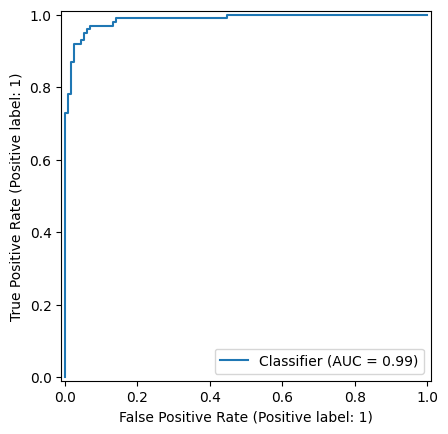

In [175]:
# Results for Gradient Boosting Classifier 3std unhealthy
print(confusion_table(boost_3std.predict(X3_test), y3_test))
print(f"Accuracy score: {boost_3std.score(X3_test, y3_test):.3f}")
print(f"ROC AUC score: {roc_auc_score(y3_test, boost_3std.predict_proba(X3_test)[:, 1]):.3f}")
roc(y3_test, boost_3std.predict_proba(X3_test)[:, 1])

In [176]:
feature_importances = pd.DataFrame({'importance':boost_3std.feature_importances_}, index=feature_names_02)
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(10)

,importance
costOfRevenue,0.215833
netIncomeRatio_income_statement,0.070396
totalDebt,0.069498
grossProfitRatio,0.068238
eps,0.065269
marketcap,0.051868
interestExpense,0.047239
epsdiluted,0.039356
propertyPlantEquipmentNet,0.036095
totalLiabilities,0.029922


Now let's do the same for the full dataset. Since the full dataset has missing values we will use a slightly different method to the Gradient Boosting Classifier. The HistGraadientBoostingClassifier is a able to handle missing values out of the box, besides that it is also faster than the GradientBoostingClassifier. 

In [177]:
# dropping year, since this caused issues in the single tree model
df.drop(columns=['year'], inplace=True)
df = df.select_dtypes(include=[np.number])

(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(df.drop(columns=['distressed']),
                                df['distressed'],
                                test_size=0.3,
                                random_state=0)
 
feature_names_03 = df.drop(columns=['distressed']).columns.tolist()

In [178]:
boost_full = HGBC(verbose=1)
boost_full.fit(X_train, y_train)

Binning 0.001 GB of training data: 0.048 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.385 s, (2336 total leaves)
Time spent computing histograms: 0.070s
Time spent finding best splits:  0.171s
Time spent applying splits:      0.029s
Time spent predicting:           0.002s


HistGradientBoostingClassifier(verbose=1)

Truth        0  1
Predicted        
0          266  3
1            1  7
Accuracy score: 0.986
ROC AUC score: 0.966


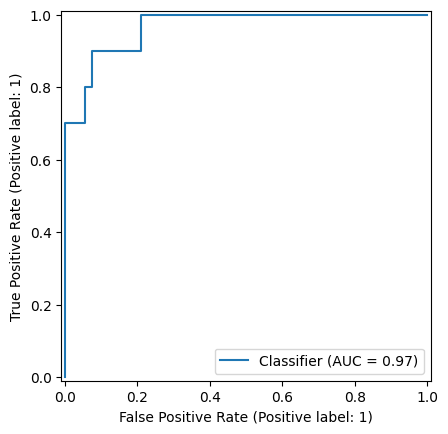

In [179]:
# Results for HistGraidnet Boosting Classifier full dataset distressed
print(confusion_table(boost_full.predict(X_test), y_test))
print(f"Accuracy score: {boost_full.score(X_test, y_test):.3f}")
print(f"ROC AUC score: {roc_auc_score(y_test, boost_full.predict_proba(X_test)[:, 1]):.3f}")
roc(y_test, boost_full.predict_proba(X_test)[:, 1])

Unfortunately, the HistGradientBoostingClassifier does not have a built-in method to show the feature importance.
But we can see, that the model is performing well with a very high accuracy. 

In [180]:
# save the new models
joblib.dump(boost_3std, './models/boost_3std.pkl')
joblib.dump(boost_full, './models/boost_full.pkl')

['./models/boost_full.pkl']

Let's move on the Random Forest Classifier. An emsemble method that uses a large number of different trees and averages their predictions. This way we end up with robust model. 

In [181]:
bag_full = RFC(random_state=0)
bag_full.fit(X_train, y_train)

bag_3std = RFC(random_state=0)
bag_3std.fit(X3_train, y3_train)

RandomForestClassifier(random_state=0)

Let's evaluate the models.

Full dataset model:
Truth        0  1
Predicted        
0          267  5
1            0  5
Accuracy score: 0.982

ROC AUC score: 0.975


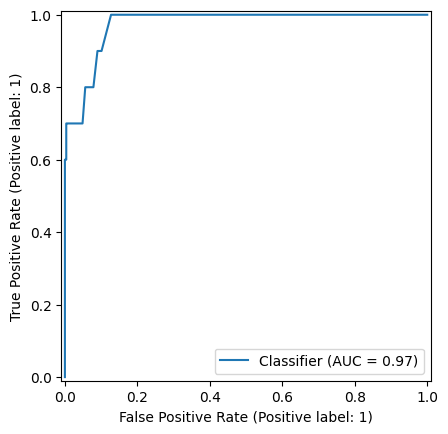

In [182]:
# Results for Random Forest Classifier full distressed
print("Full dataset model:")
print(confusion_table(bag_full.predict(X_test), y_test))
print(f"Accuracy score: {bag_full.score(X_test, y_test):.3f}\n")
print(f"ROC AUC score: {roc_auc_score(y_test, bag_full.predict_proba(X_test)[:, 1]):.3f}")
roc(y_test, bag_full.predict_proba(X_test)[:, 1])



3std dataset model:
Truth      0.0  1.0
Predicted          
0.0        109   19
1.0          5   81
Accuracy score: 0.888

ROC AUC score: 0.974


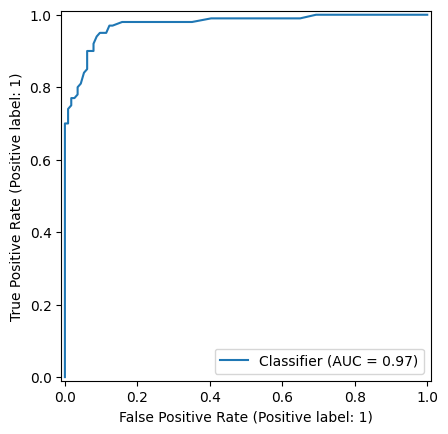

In [183]:
# Results for Random Forest Classifier 3std unhealthy
print("3std dataset model:")
print(confusion_table(bag_3std.predict(X3_test), y3_test))
print(f"Accuracy score: {bag_3std.score(X3_test, y3_test):.3f}\n")
print(f"ROC AUC score: {roc_auc_score(y3_test, bag_3std.predict_proba(X3_test)[:, 1]):.3f}")
roc(y3_test, bag_3std.predict_proba(X3_test)[:, 1])

Let's also look at the feature importance for both models

In [184]:
print("Feature importances for the full dataset model:")
feature_importances = pd.DataFrame({'importance':bag_full.feature_importances_}, index=feature_names_03)
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(10)

Feature importances for the full dataset model:


,importance
weightedAverageShsOutDil,0.039752
weightedAverageShsOut,0.035649
othertotalStockholdersEquity,0.030892
revenue,0.027371
costAndExpenses,0.027170
operatingExpenses,0.023716
commonStockIssued,0.021370
netIncomeRatio_income_statement,0.020785
grossProfit,0.019660
operatingIncomeRatio,0.019174


In [185]:
print("Feature importances for the 3std dataset model:")
feature_importances = pd.DataFrame({'importance':bag_3std.feature_importances_}, index=feature_names_02)
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(10)

Feature importances for the 3std dataset model:


,importance
costOfRevenue,0.056179
grossProfitRatio,0.039532
epsdiluted,0.030973
netIncomeRatio_income_statement,0.030475
retainedEarnings,0.027104
interestExpense,0.026067
incomeBeforeTaxRatio,0.026065
totalDebt,0.024157
marketcap,0.020987
eps,0.020528


In [186]:
# save the models
joblib.dump(bag_full, './models/forest_full.pkl')
joblib.dump(bag_3std, './models/forest_3std.pkl')

['./models/forest_3std.pkl']

Our forests already have decent results, but we can try to improve them by using more trees. By default the RandomForestClassifier uses 100 trees, but we can increase this number to 5000 (possibly too much), and see if this improves the accuracy of the model or if it changes the feture importance in any significant way.

In [187]:
bag_full_02 = RFC(n_estimators=5000, random_state=0)
bag_full_02.fit(X_train, y_train)

bag_3std_02 = RFC(n_estimators=5000, random_state=0)
bag_3std_02.fit(X3_train, y3_train)

RandomForestClassifier(n_estimators=5000, random_state=0)

Full dataset model:
Truth        0  1
Predicted        
0          267  5
1            0  5
Accuracy score: 0.982

ROC AUC score: 0.989


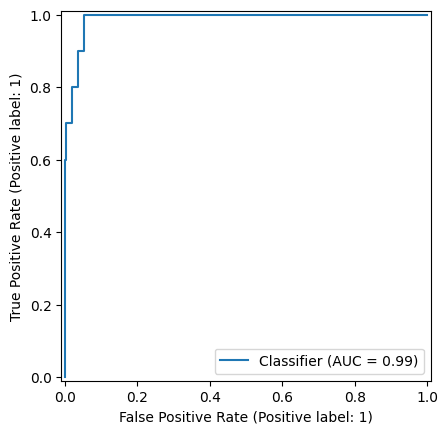

In [188]:
# Results for Random Forest Classifier full distressed 5k trees
print("Full dataset model:")
print(confusion_table(bag_full_02.predict(X_test), y_test))
print(f"Accuracy score: {bag_full_02.score(X_test, y_test):.3f}\n")
print(f"ROC AUC score: {roc_auc_score(y_test, bag_full_02.predict_proba(X_test)[:, 1]):.3f}")
roc(y_test, bag_full_02.predict_proba(X_test)[:, 1])


3std dataset model:
Truth      0.0  1.0
Predicted          
0.0        110   16
1.0          4   84
Accuracy score: 0.907

ROC AUC score: 0.978


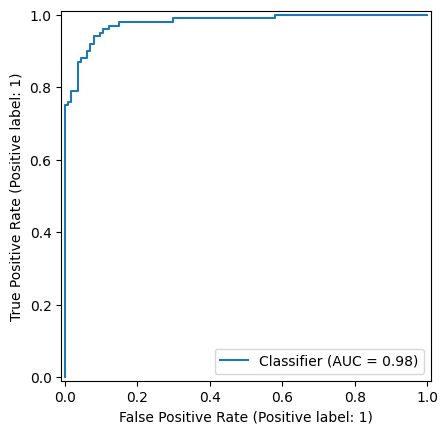

In [189]:
# Results for Random Firest Classifier 3std unhealthy 5k trees
print("3std dataset model:")
print(confusion_table(bag_3std_02.predict(X3_test), y3_test))
print(f"Accuracy score: {bag_3std_02.score(X3_test, y3_test):.3f}\n")
print(f"ROC AUC score: {roc_auc_score(y3_test, bag_3std_02.predict_proba(X3_test)[:, 1]):.3f}")
roc(y3_test, bag_3std_02.predict_proba(X3_test)[:, 1])

The accuracy of the full dataset model did not improve. It seems to reach a plateau already at 100 trees, this might be due to the imbalance in the dataset (small number of distressed companies). The 3std dataset model did improve a little, just enough to reach the 90% accuracy mark.

In [190]:
print("Feature importances for the full dataset model:")
feature_importances = pd.DataFrame({'importance':bag_full_02.feature_importances_}, index=feature_names_03)
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(10)

Feature importances for the full dataset model:


,importance
othertotalStockholdersEquity,0.032305
revenue,0.030508
costAndExpenses,0.028391
operatingExpenses,0.024405
retainedEarnings,0.022091
operatingIncomeRatio,0.021359
weightedAverageShsOutDil,0.020587
weightedAverageShsOut,0.019816
ebitdaratio,0.019051
accumulatedOtherComprehensiveIncomeLoss,0.018780


In [191]:
print("Feature importances for the 3std dataset model:")
feature_importances = pd.DataFrame({'importance':bag_3std_02.feature_importances_}, index=feature_names_02)
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(10)

Feature importances for the 3std dataset model:


,importance
costOfRevenue,0.057275
grossProfitRatio,0.044843
totalDebt,0.029941
netIncomeRatio_income_statement,0.029931
epsdiluted,0.026748
interestExpense,0.024914
eps,0.024587
incomeBeforeTaxRatio,0.022867
retainedEarnings,0.021713
researchAndDevelopmentExpenses,0.019672


In [192]:
# save the models
joblib.dump(bag_full_02, './models/forest_full_02.pkl')
joblib.dump(bag_3std_02, './models/forest_3std_02.pkl')

['./models/forest_3std_02.pkl']

We can attempt to resample the dataset and create dummy data for the full dataset, to see if can counter the imbalance in the dataset and further imrpove the accuracy of the model. As of now, there is a chance that the model is overfitting, since the high accuracy is reached very quickly.

In [193]:
# fresh import of the dataset
df2 = pd.read_csv('./datasets/full_cleaned_dataset.csv')
imputer = KNNImputer()

y = np.asarray(df2['distressed'].values)
df2.drop(columns=['distressed'], inplace=True)
model = MS(df2.select_dtypes(include=np.number).columns, intercept=False)
D = model.fit_transform(df2)
feature_names_04 = list(D.columns)
X = np.asarray(D)
X = imputer.fit_transform(X)

# create dummy data using SMOTE
X_res, y_res = SMOTE(random_state=0).fit_resample(X, y)

print(f"Original dataset shape {Counter(y)}")
print(f"Resampled dataset shape {Counter(y_res)}")


Original dataset shape Counter({0: 889, 1: 32})
Resampled dataset shape Counter({0: 889, 1: 889})


In [194]:
# splitting the data into training and test sets
(X_res_train,
 X_res_test,
 y_res_train,
 y_res_test) = skm.train_test_split(X_res,
                                y_res,
                                test_size=0.3,
                                random_state=0)

In [195]:
bag_full_03 = RFC(n_estimators=1000, random_state=0)
bag_full_03.fit(X_res_train, y_res_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

Full resampled model:
Truth        0    1
Predicted          
0          266    0
1            0  268
Accuracy score: 1.000

ROC AUC score: 1.000


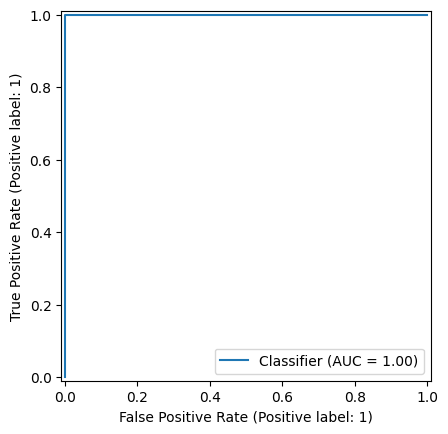

In [196]:
# Results for Random Forest Classifier smote distressed 
print("Full resampled model:")
print(confusion_table(bag_full_03.predict(X_res_test), y_res_test))
print(f"Accuracy score: {bag_full_03.score(X_res_test, y_res_test):.3f}\n")
print(f"ROC AUC score: {roc_auc_score(y_res_test, bag_full_03.predict_proba(X_res_test)[:, 1]):.3f}")
roc(y_res_test, bag_full_03.predict_proba(X_res_test)[:, 1])

In [197]:
print("Feature importances for the full dataset model:")
feature_importances = pd.DataFrame({'importance':bag_full_03.feature_importances_}, index=feature_names_04)
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(10)

Feature importances for the full dataset model:


,importance
retainedEarnings,0.062210
epsdiluted,0.061383
eps,0.053251
othertotalStockholdersEquity,0.048618
netCashProvidedByOperatingActivities,0.032797
operatingCashFlow,0.030762
stockBasedCompensation,0.023601
totalLiabilitiesAndTotalEquity,0.022459
costAndExpenses,0.022297
year,0.022065


In [198]:
# save model
joblib.dump(bag_full_03, './models/forest_full_03.pkl')

['./models/forest_full_03.pkl']